# Package loading and basic configurations

In [18]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Gievenbeck, Münster (Germany) and requests 50 tracks. The result is a GeoDataFrame, which is a geo-extended Pandas dataframe from the GeoPandas library. It contains all information of the track in a flat dataframe format including a specific geometry column. 

In [27]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=50) # requesting 10 tracks inside the bbox
track_df



id                 time                  geometry  \
0   5de9d7a03bdb691868e76542  2019-11-29T12:24:48  POINT (7.60302 51.93549)   
1   5de9d7a03bdb691868e76544  2019-11-29T12:24:53  POINT (7.60279 51.93574)   
2   5de9d7a03bdb691868e76545  2019-11-29T12:24:58  POINT (7.60318 51.93579)   
3   5de9d7a03bdb691868e76546  2019-11-29T12:25:03  POINT (7.60354 51.93574)   
4   5de9d7a03bdb691868e76547  2019-11-29T12:25:08  POINT (7.60403 51.93611)   
..                       ...                  ...                       ...   
30  575a63b9e4b0a691929d1ee2  2016-06-09T16:11:12  POINT (7.57763 51.95973)   
31  575a63b9e4b0a691929d1ee3  2016-06-09T16:11:17  POINT (7.57684 51.95933)   
32  575a63b9e4b0a691929d1ee4  2016-06-09T16:11:22  POINT (7.57604 51.95899)   
33  575a63b9e4b0a691929d1ee5  2016-06-09T16:11:27  POINT (7.57522 51.95865)   
34  575a63b9e4b0a691929d1ee6  2016-06-09T16:11:32  POINT (7.57425 51.95818)   

    GPS HDOP.value GPS HDOP.unit  Throttle Position.value  \
0         0.800000     precision                13.000000   
1         0.800000     precision                15.000000   
2         0.900000     precision                16.000000   
3         0.882600     precision                30.999999   
4         0.800000     precision                13.000000   
..             ...           ...                      ...   
30        0.916525     precision                17.999999   
31        1.300000     precision                18.000000   
32        1.000000     precision                20.467706   
33        0.800000     precision                16.000000   
34        0.960672     precision                13.302198   

   Throttle Position.unit  Intake Temperature.value Intake Temperature.unit  \
0                       %                  8.000000                       c   
1                       %                  7.000000                       c   
2                       %                  8.000000                       c   
3                       %                  7.786344                       c   
4                       %                  7.000000                       c   
..                    ...                       ...                     ...   
30                      %                 24.000000                       c   
31                      %                 24.000000                       c   
32                      %                 24.000000                       c   
33                      %                 24.000000                       c   
34                      %                 25.863637                       c   

      Rpm.value  ... MAF.value  MAF.unit O2 Lambda Voltage ER.value  \
0    763.163669  ...       NaN       NaN                        NaN   
1   1701.677369  ...       NaN       NaN                        NaN   
2   1361.423041  ...       NaN       NaN                        NaN   
3   1951.543919  ...       NaN       NaN                        NaN   
4    792.443191  ...       NaN       NaN                        NaN   
..          ...  ...       ...       ...                        ...   
30  1866.000000  ...       NaN       NaN                        NaN   
31  1853.205298  ...       NaN       NaN                        NaN   
32  1840.097751  ...       NaN       NaN                        NaN   
33  1926.970989  ...       NaN       NaN                        NaN   
34   950.486984  ...       NaN       NaN                        NaN   

    O2 Lambda Voltage ER.unit O2 Lambda Voltage.value  O2 Lambda Voltage.unit  \
0                         NaN                     NaN                     NaN   
1                         NaN                     NaN                     NaN   
2                         NaN                     NaN                     NaN   
3                         NaN                     NaN                     NaN   
4                         NaN                     NaN                     NaN   
..                        ...                     ...   

In [28]:
track_df.plot(figsize=(8, 10))

# Inspecting a single Track

In [23]:
some_track_id = track_df['track.id'].unique()[1]

some_track = track_df[track_df['track.id'] == some_track_id]
some_track.plot()

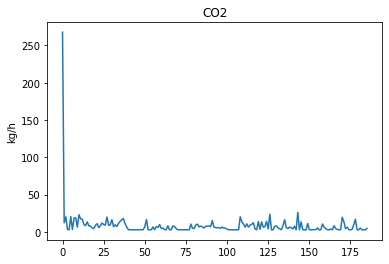

In [26]:
ax = some_track['CO2.value'].plot()
ax.set_title("CO2")
ax.set_ylabel(some_track['CO2.unit'][0])
ax

## Interactive Map
The following map-based visualization makes use of folium. It allows to visualizate geospatial data based on an interactive leaflet map. Since the data in the GeoDataframe is modelled as a set of Point instead of a LineString, we have to manually create a polyline

In [25]:
import folium

lats = list(some_track['geometry'].apply(lambda coord: coord.y))
lngs = list(some_track['geometry'].apply(lambda coord: coord.x))

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)

m = folium.Map(location=[avg_lat, avg_lngs], zoom_start=13)
folium.PolyLine([coords for coords in zip(lats, lngs)], color='blue').add_to(m)
m

# Example: Visualization with pydeck (deck.gl)

The pydeck library makes use of the basemap tiles from Mapbox. In case you want to visualize the map with basemap tiles, you need to register with MapBox, and configure a specific access token. The service is free until a certain level of traffic is esceeded.

You can either configure it via your terminal (i.e. `export MAPBOX_API_KEY=<mapbox-key-here>`), which pydeck will automatically read, or you can pass it as a variable to the generation of pydeck (i.e. `pdk.Deck(mapbox_key=<mapbox-key-here>, ...)`.

In [9]:
import pydeck as pdk

# for pydeck the attributes have to be flat
track_df['lat'] = track_df['geometry'].apply(lambda coord: coord.y)
track_df['lng'] = track_df['geometry'].apply(lambda coord: coord.x)
vis_df = pd.DataFrame(track_df)
vis_df['speed'] = vis_df['Speed.value']

# omit unit columns
vis_df_cols = [col for col in vis_df.columns if col.lower()[len(col)-4:len(col)] != 'unit']
vis_df = vis_df[vis_df_cols]

layer = pdk.Layer(
    'ScatterplotLayer',
    data=vis_df,
    get_position='[lng, lat]',
    auto_highlight=True,
    get_radius=10,          # Radius is given in meters
    get_fill_color='[speed < 20 ? 0 : (speed - 20)*8.5, speed < 50 ? 255 : 255 - (speed-50)*8.5, 0, 140]',  # Set an RGBA value for fill
    pickable=True
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=7.5963592529296875,
    latitude=51.96246168188569,
    zoom=10,
    min_zoom=5,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

r = pdk.Deck(
    width=200, 
    layers=[layer], 
    initial_view_state=view_state #, mapbox_key=<mapbox-key-here>
)
r.to_html('tracks_muenster.html', iframe_width=900)

'f:\\Dokumente\\Uni_Msc\\2020_SS\\FCDA_Study_Project\\envirocar-py\\examples\\tracks_muenster.html'

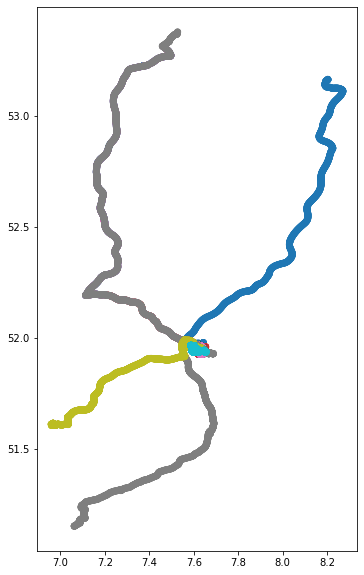

In [10]:
# Visualizing tracks by their IDs
by_id = track_df.dissolve(by='track.id')
by_id.plot(column = 'id', figsize=(8, 10))

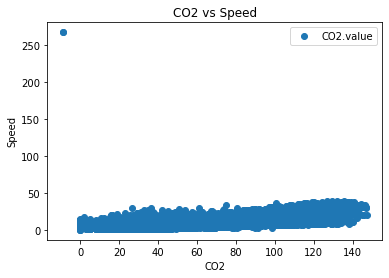

In [11]:
# Summary statistics - plotting Speed values against CO2 values to see if there's a trend

# dataframe of all tracks without geometries
track_df_pd = pd.DataFrame(track_df)
ax2 = track_df_pd.plot(x='Speed.value', y='CO2.value', style='o')
ax2.set_title("CO2 vs Speed")
ax2.set_xlabel("CO2")
ax2.set_ylabel("Speed")
ax2

In [12]:
# Additional visualization framework for just one track, using Plotly

import plotly.express as px

some_track_flat = vis_df[vis_df['track.id'] == some_track_id]

fig = px.scatter_mapbox(some_track_flat, lat="lat", lon="lng", color="CO2.value", size="CO2.value", title="CO2 values along the track")
fig.update_layout(mapbox_style="open-street-map")
fig.show()


Since there is clearly an outlier, we should remove it by using the statistical approach as described in
https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm

In [13]:
first_quartile = some_track_flat['CO2.value'].quantile(0.25)
third_quartile = some_track_flat['CO2.value'].quantile(0.75)
iqr = third_quartile-first_quartile # Interquartile range
fence_low  = first_quartile-1.5*iqr
fence_high = third_quartile+1.5*iqr
some_track_cleaned = some_track_flat.loc[(some_track_flat['CO2.value'] > fence_low) & (some_track_flat['CO2.value'] < fence_high)]

fig2 = px.scatter_mapbox(some_track_cleaned, lat="lat", lon="lng", color="CO2.value", title="CO2 values along the track, cleaned")
fig2.update_layout(mapbox_style="open-street-map")
fig2.show()